# TSF Final Assignment
## Murat Tirkeshov
### Kaggle competition

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import arma_order_select_ic
from arch import arch_model
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from tbats import TBATS
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
import pmdarima as pm
from prophet import Prophet
from itertools import product
from statsmodels.tsa.stattools import grangercausalitytests
import itertools
import plotly.express as px

from prophet import Prophet

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

##  Data
### Merging given data sets

In [3]:
df = pd.read_csv('store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
submission = pd.read_csv('store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
stores = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
transactions = pd.read_csv('store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
holidays = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])

In [4]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
df = df.merge(stores, on='store_nbr', how='left')
submission = submission.merge(stores, on='store_nbr', how='left')
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [6]:
df = df.merge(transactions, on=['date', 'store_nbr'], how='left')
submission = submission.merge(transactions, on=['date', 'store_nbr'], how='left')
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [7]:
oil = oil.set_index('date').resample('D').mean().interpolate()
oil.reset_index(inplace=True)
df = df.merge(oil, on='date', how='left')
submission = submission.merge(oil, on='date', how='left')
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN


In [8]:
def process_holidays(df):
    df = df.copy()
    df['is_holiday'] = 1
    df = df[['date', 'is_holiday', 'type', 'locale']]
    df = df.drop_duplicates('date')
    df = df.pivot_table(index='date', 
                        values='is_holiday', 
                        aggfunc='max').reset_index()
    return df

holiday_features = process_holidays(holidays)
df = df.merge(holiday_features, on='date', how='left')
submission = submission.merge(holiday_features, on='date', how='left')


df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0


### Missing values

In [9]:
df['transactions'] = df['transactions'].fillna(df['transactions'].median())
submission['transactions'] = submission['transactions'].fillna(submission['transactions'].median())
df['dcoilwtico'] = df['dcoilwtico'].fillna(df['dcoilwtico'].mean())
submission['dcoilwtico'] = submission['dcoilwtico'].fillna(submission['dcoilwtico'].mean())

### Adding aditional variables

In [10]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_weekend_and_holiday'] = ((df['is_weekend'] == 1) & (df['is_holiday'] == 1)).astype(int)
submission['day'] = submission['date'].dt.day
submission['month'] = submission['date'].dt.month
submission['year'] = submission['date'].dt.year
submission['day_of_week'] = submission['date'].dt.dayofweek
submission['is_weekend'] = (submission['day_of_week'] >= 5).astype(int)
submission['is_weekend_and_holiday'] = ((submission['is_weekend'] == 1) & (submission['is_holiday'] == 1)).astype(int)

In [11]:
df['is_holiday'] = df['is_holiday'].fillna(0)
submission['is_holiday'] = submission['is_holiday'].fillna(0)

## Data Visualization

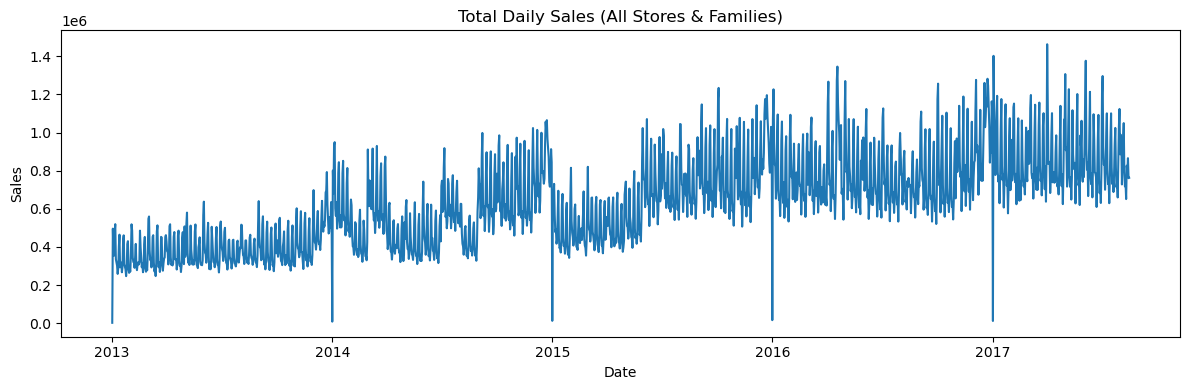

In [12]:
daily = df.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(daily['date'], daily['sales'])
plt.title('Total Daily Sales (All Stores & Families)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

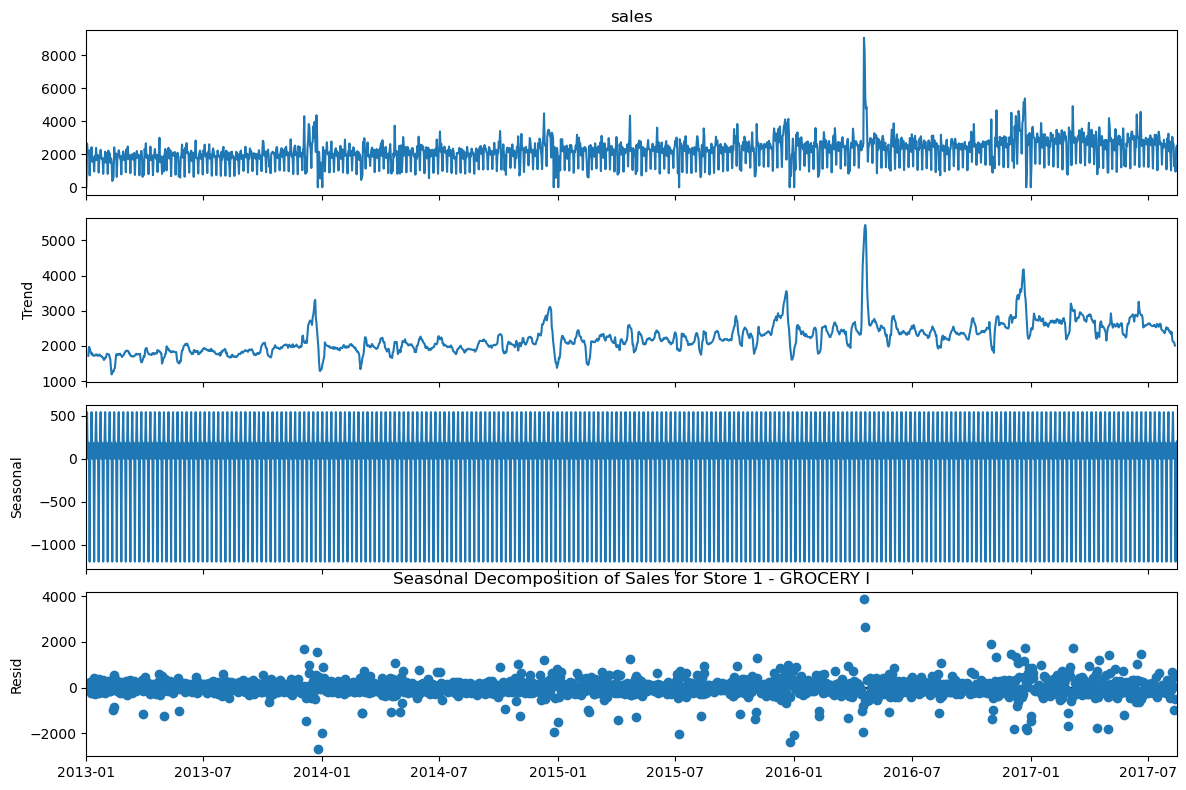

In [63]:
mask = (df['store_nbr']==1) & (df['family']=='GROCERY I')
ts = df[mask].set_index('date')['sales'].asfreq('D').fillna(0)
decomp = seasonal_decompose(ts, model='additive', period=7)
fig = decomp.plot()
fig.set_size_inches(12,8)
plt.tight_layout()
plt.title('Seasonal Decomposition of Sales for Store 1 - GROCERY I')
plt.show()

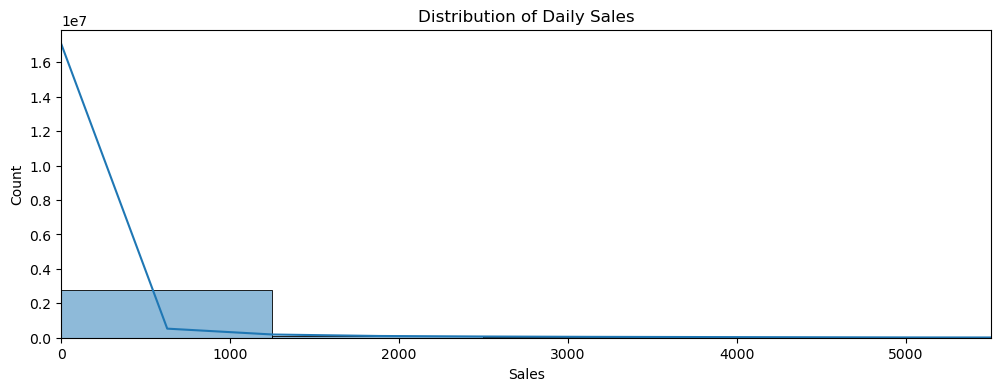

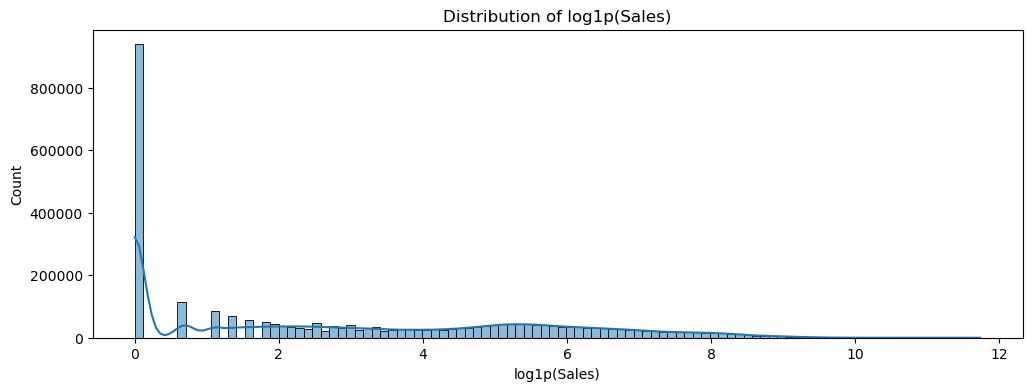

In [14]:
plt.figure(figsize=(12,4))
sns.histplot(df['sales'], bins=100, kde=True)
plt.xlim(0, df['sales'].quantile(0.99))
plt.title('Distribution of Daily Sales')
plt.xlabel('Sales')
plt.show()

plt.figure(figsize=(12,4))
sns.histplot(np.log1p(df['sales']), bins=100, kde=True)
plt.title('Distribution of log1p(Sales)')
plt.xlabel('log1p(Sales)')
plt.show()

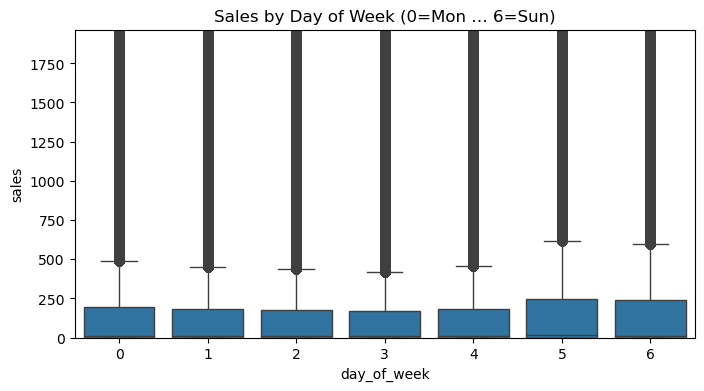

In [15]:
plt.figure(figsize=(8,4))
sns.boxplot(x='day_of_week', y='sales', data=df)
plt.ylim(0, df['sales'].quantile(0.95))
plt.title('Sales by Day of Week (0=Mon … 6=Sun)')
plt.show()

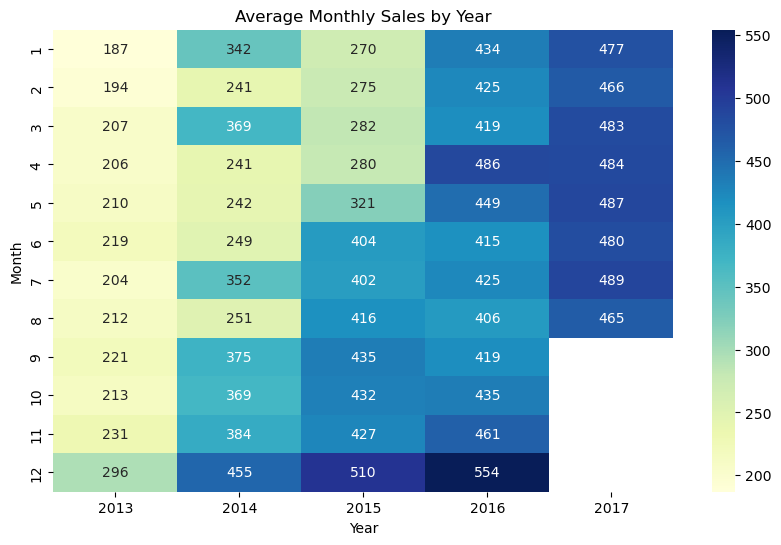

In [16]:
pivot = df.groupby(['year','month'])['sales'].mean().unstack(level=0)
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Average Monthly Sales by Year')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

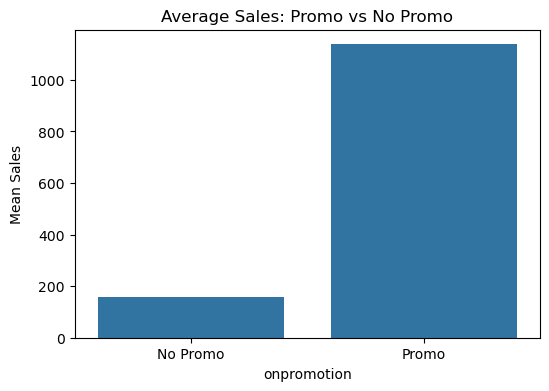

In [17]:
promo = df.copy()
promo['onpromotion'] = promo['onpromotion'] > 0
mean_sales = promo.groupby('onpromotion')['sales'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x='onpromotion', y='sales', data=mean_sales)
plt.xticks([0,1], ['No Promo','Promo'])
plt.title('Average Sales: Promo vs No Promo')
plt.ylabel('Mean Sales')
plt.show()

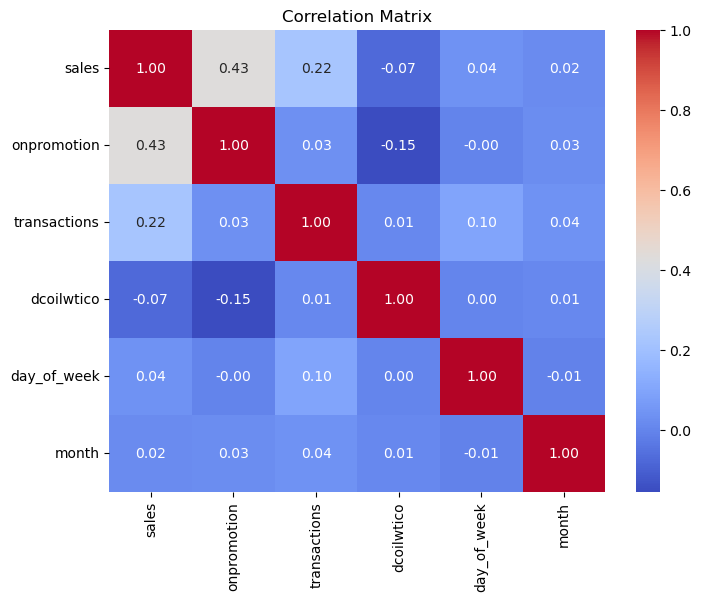

In [18]:
num_cols = ['sales','onpromotion','transactions','dcoilwtico','day_of_week','month']
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

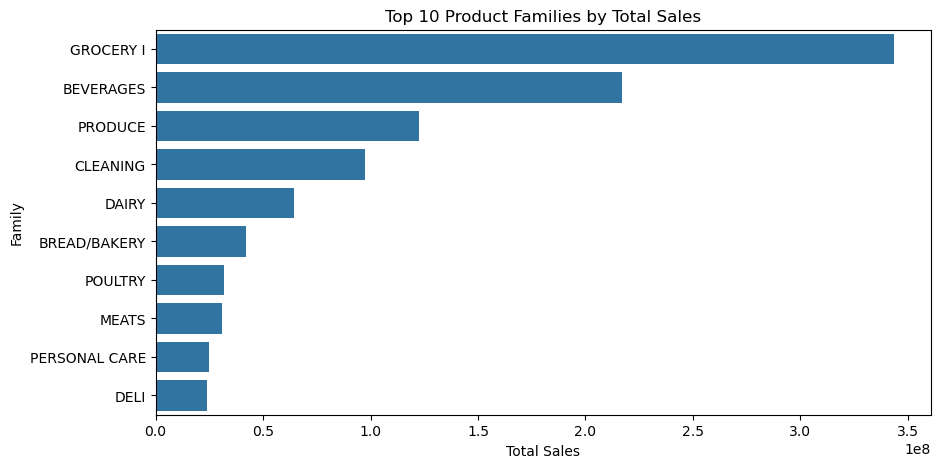

In [19]:
family_sales = df.groupby('family')['sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=family_sales.values, y=family_sales.index)
plt.title('Top 10 Product Families by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Family')
plt.show()

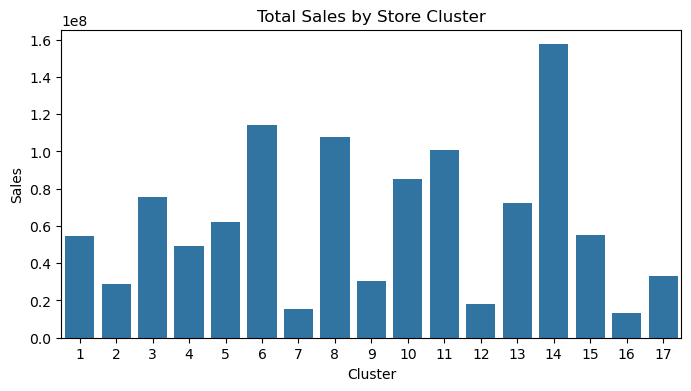

In [20]:
cluster_sales = df.groupby('cluster')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=cluster_sales.index, y=cluster_sales.values)
plt.title('Total Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Sales')
plt.show()

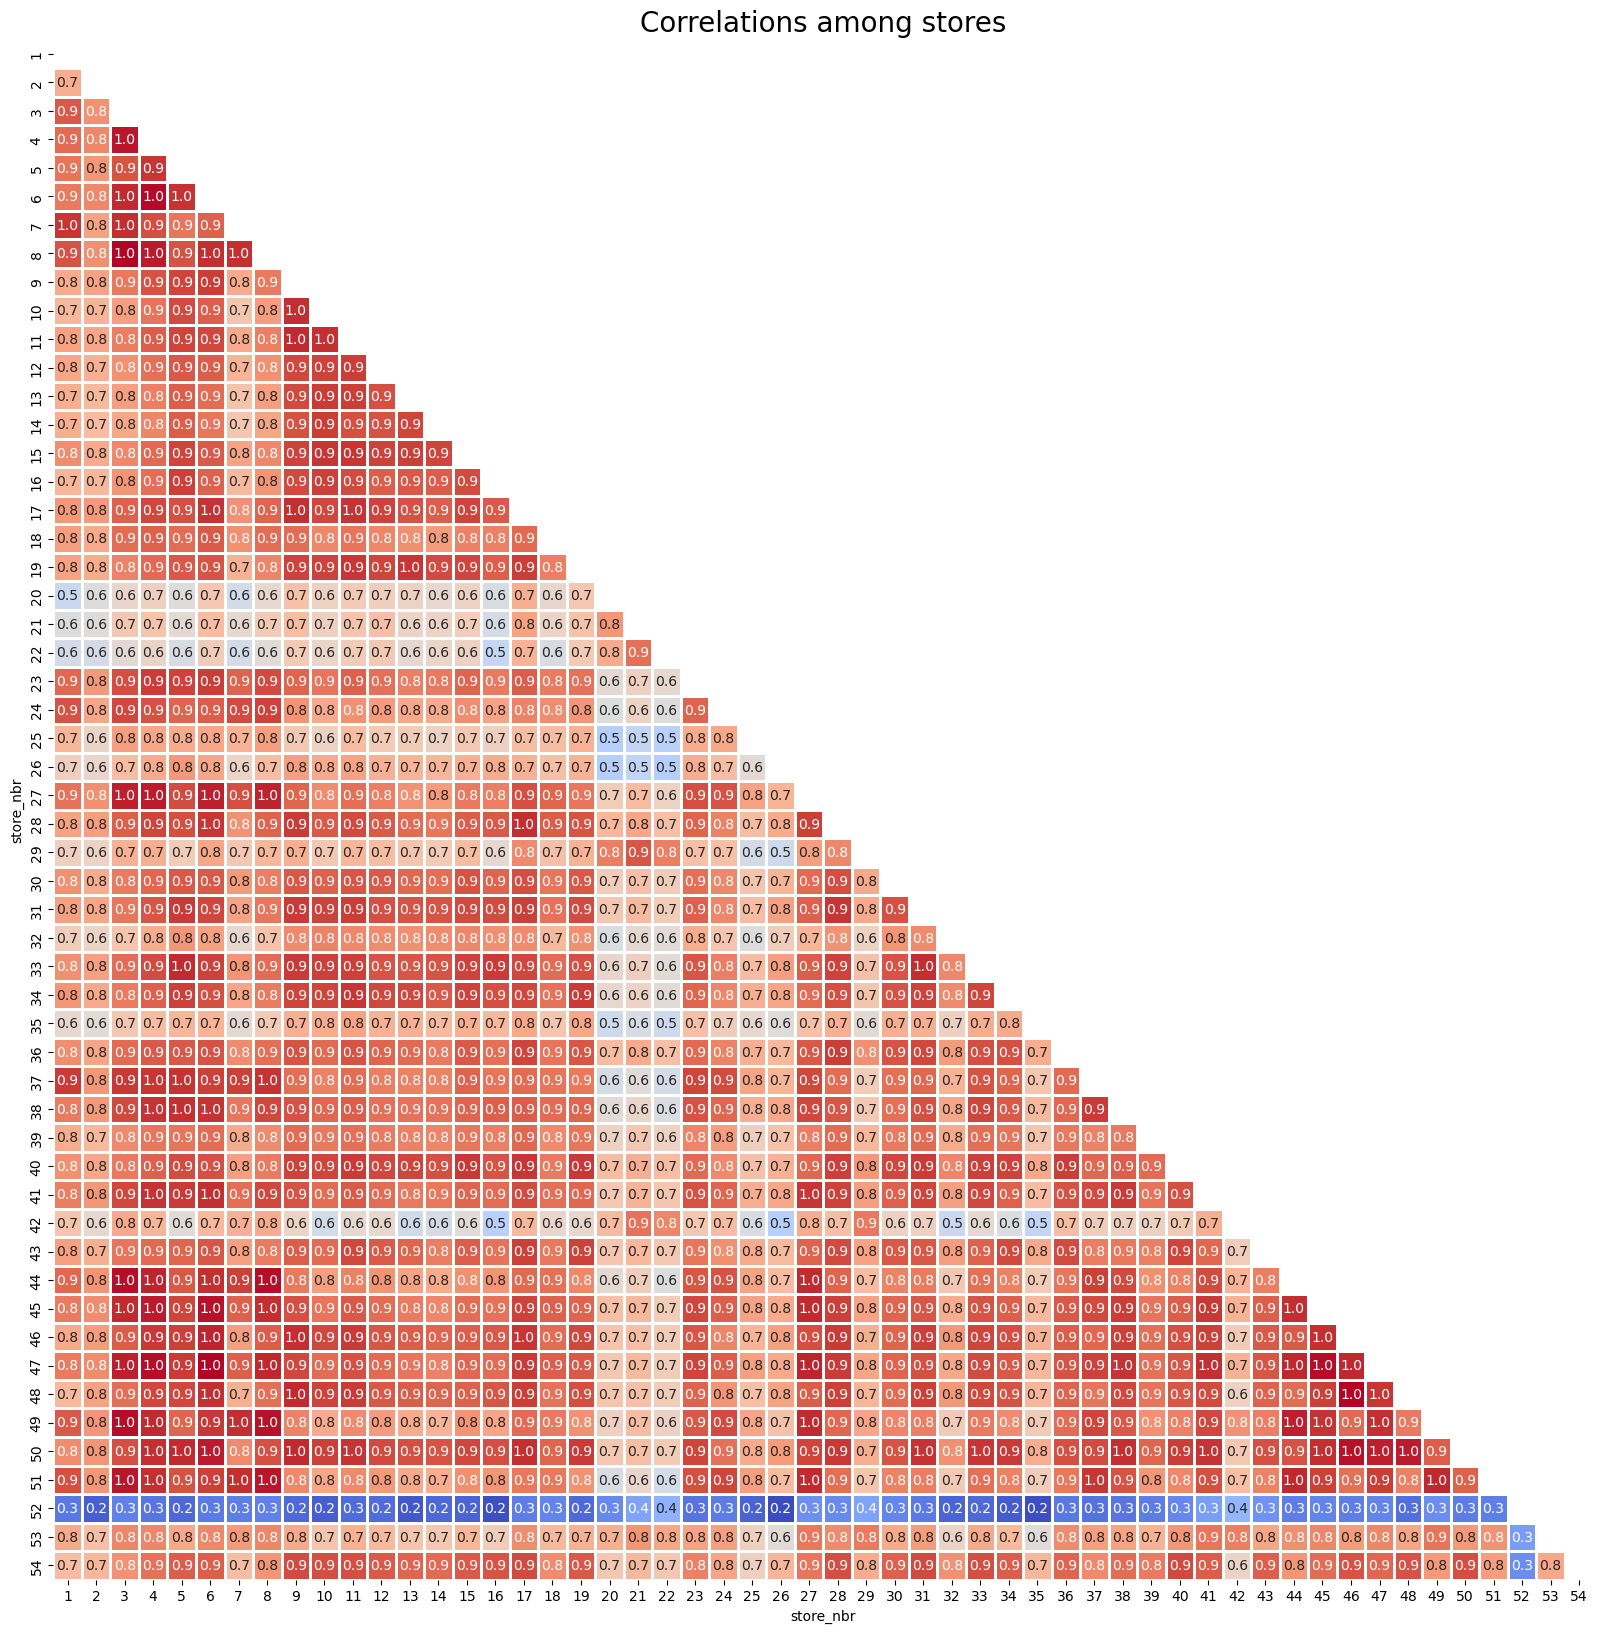

In [21]:
a = df[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

### ACF and PACF for store 1

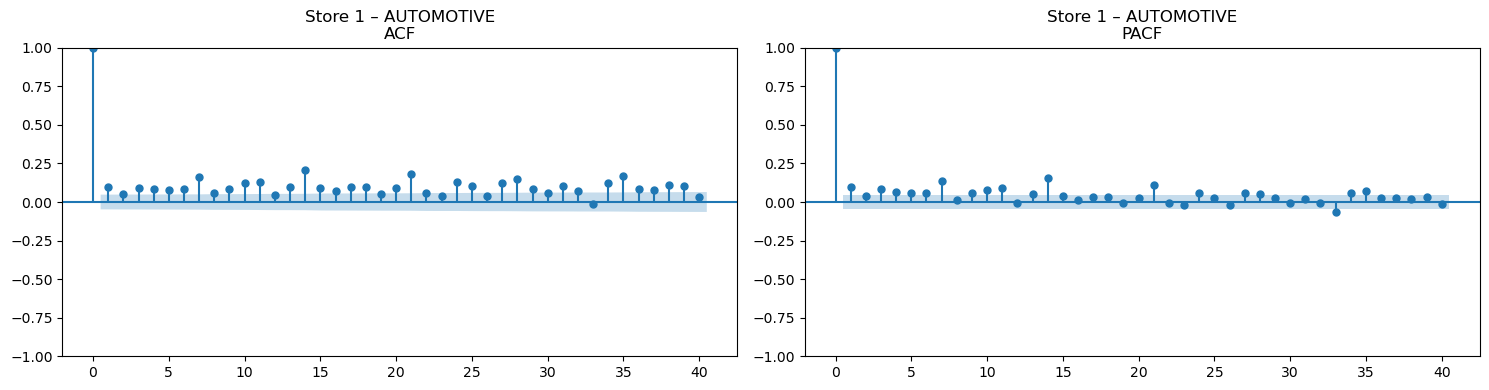

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1491: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


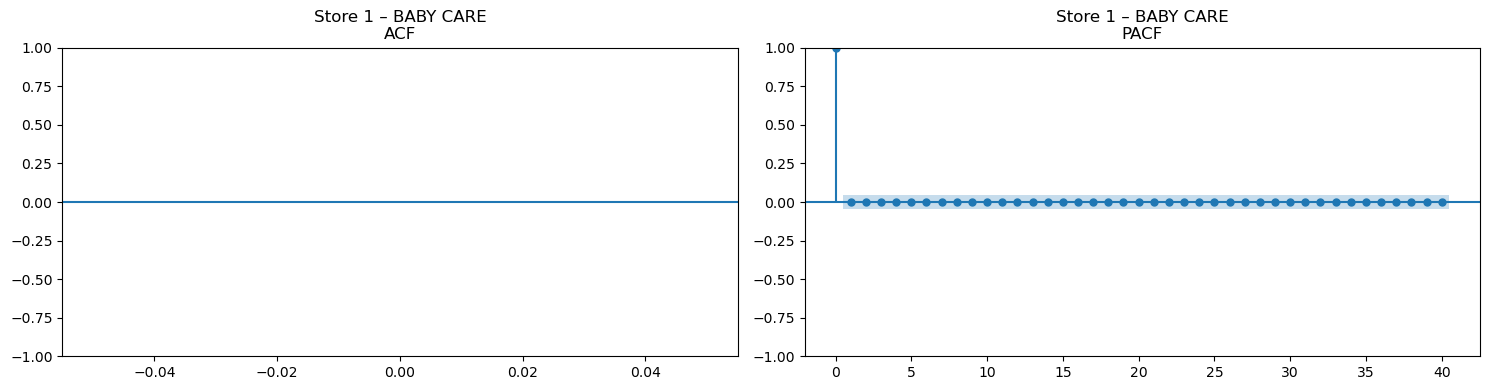

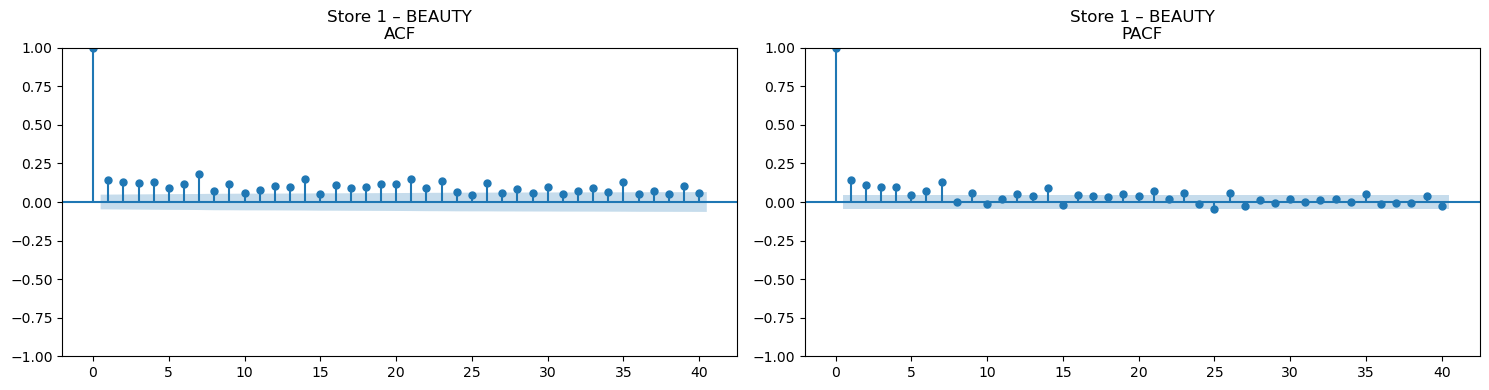

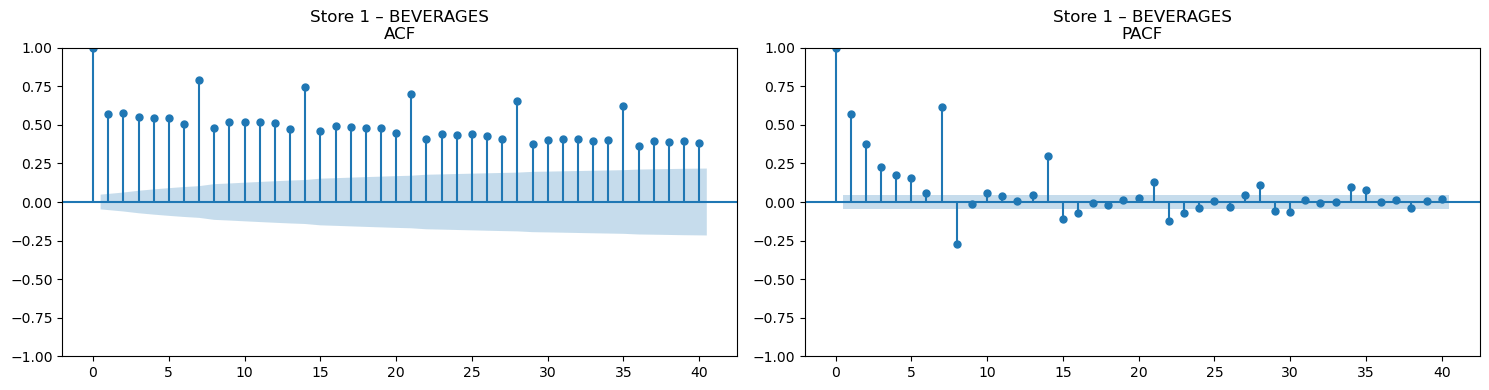

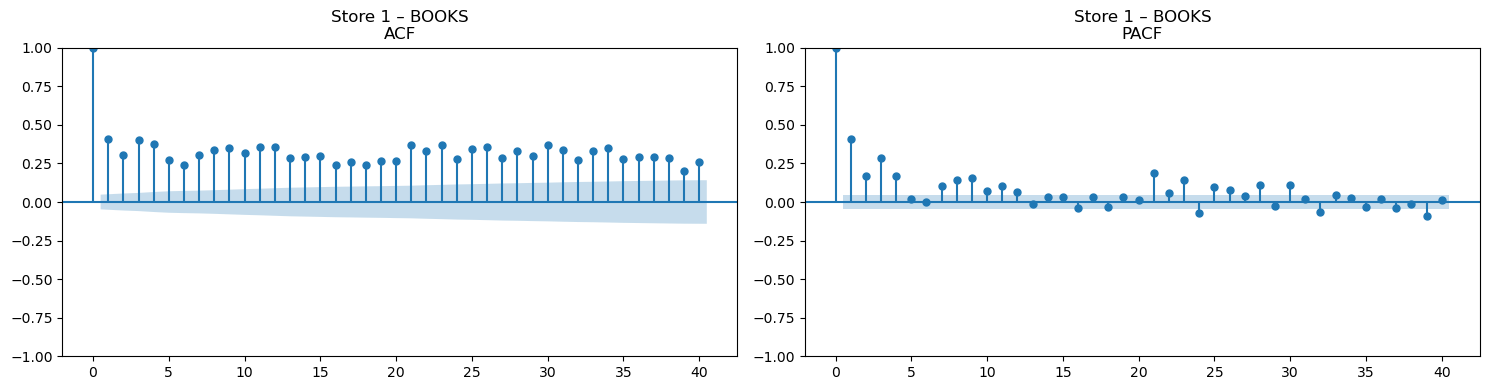

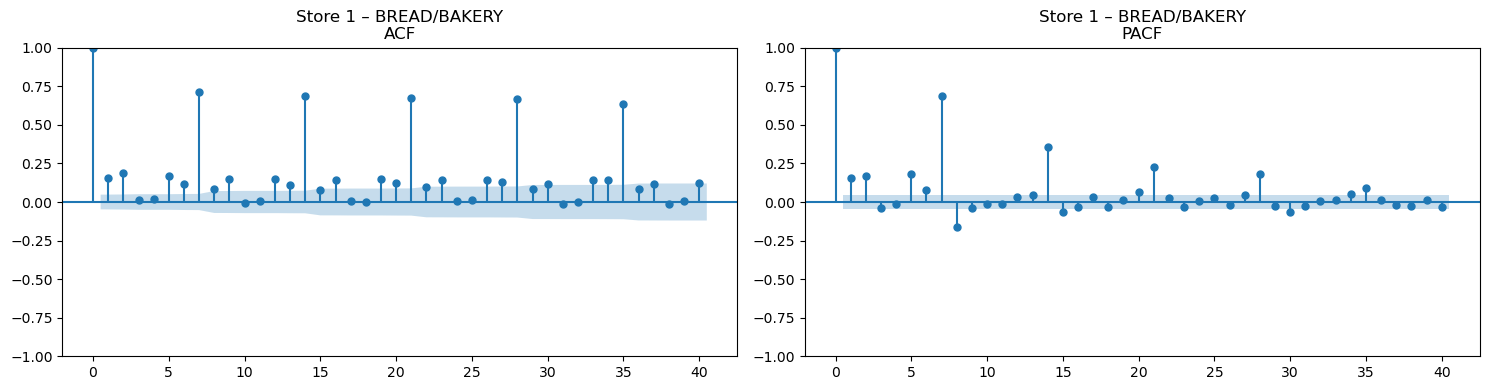

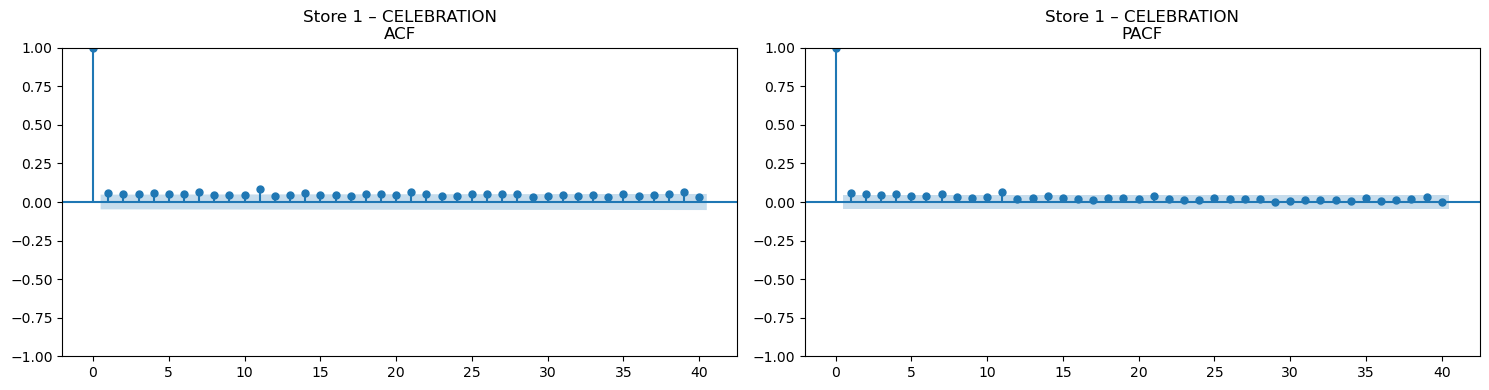

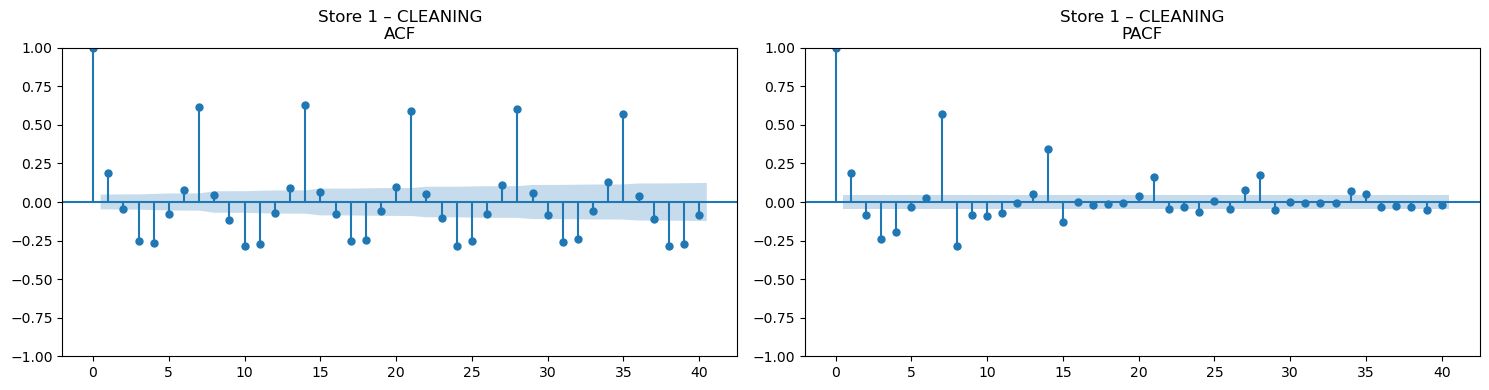

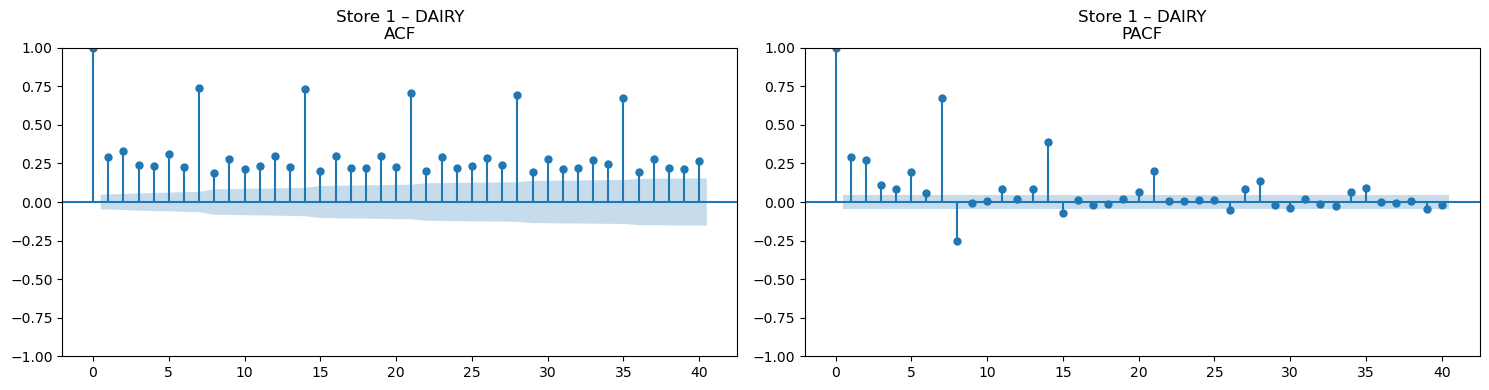

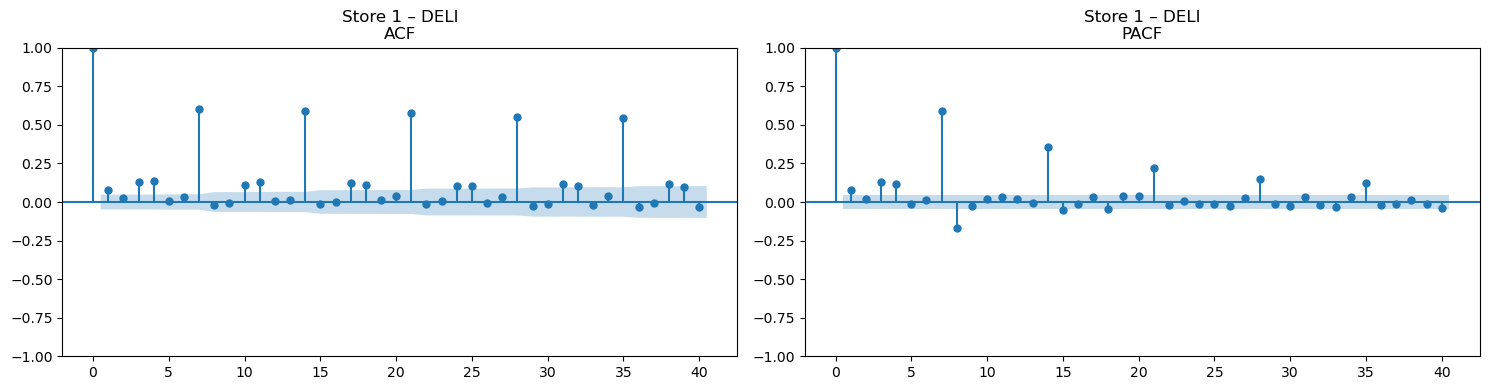

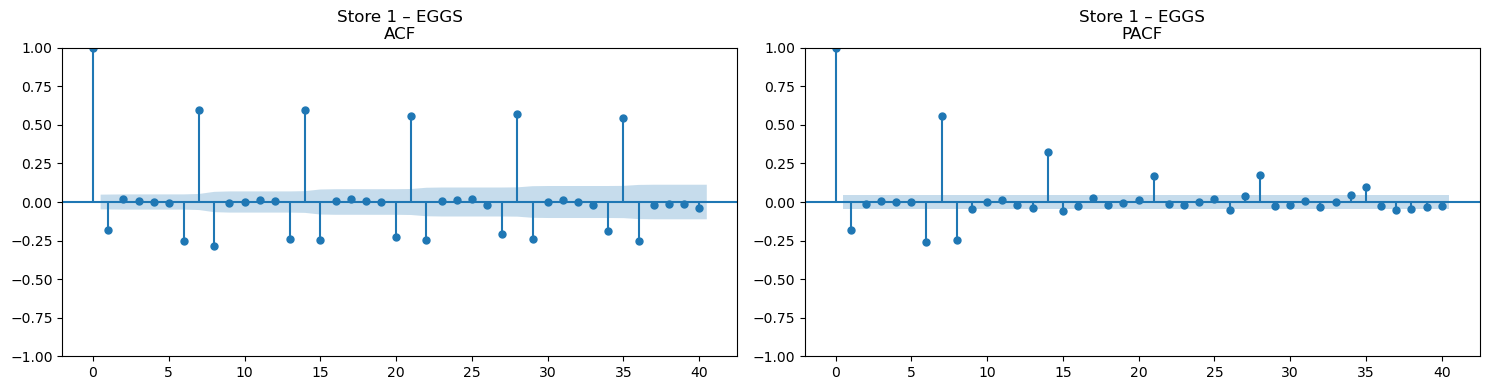

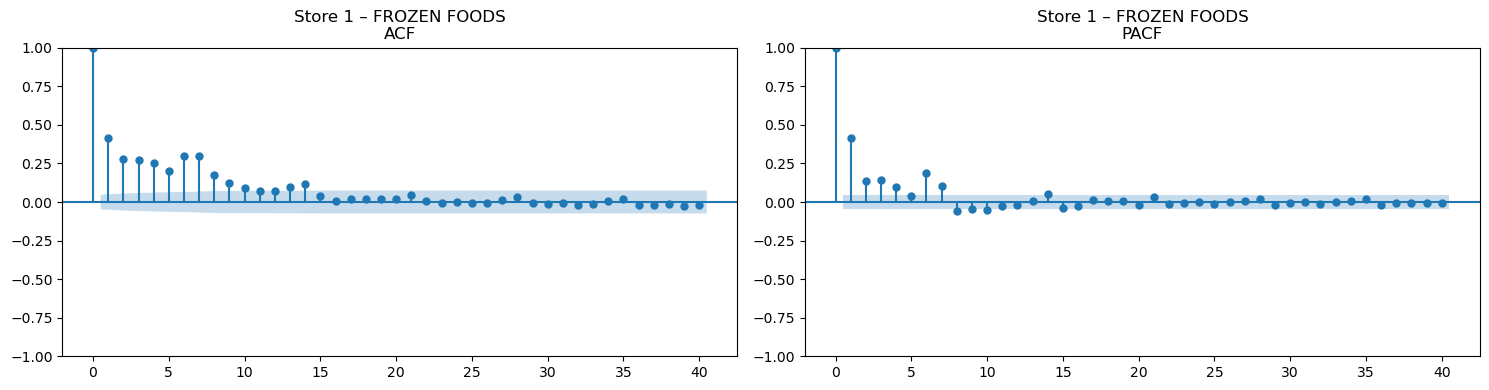

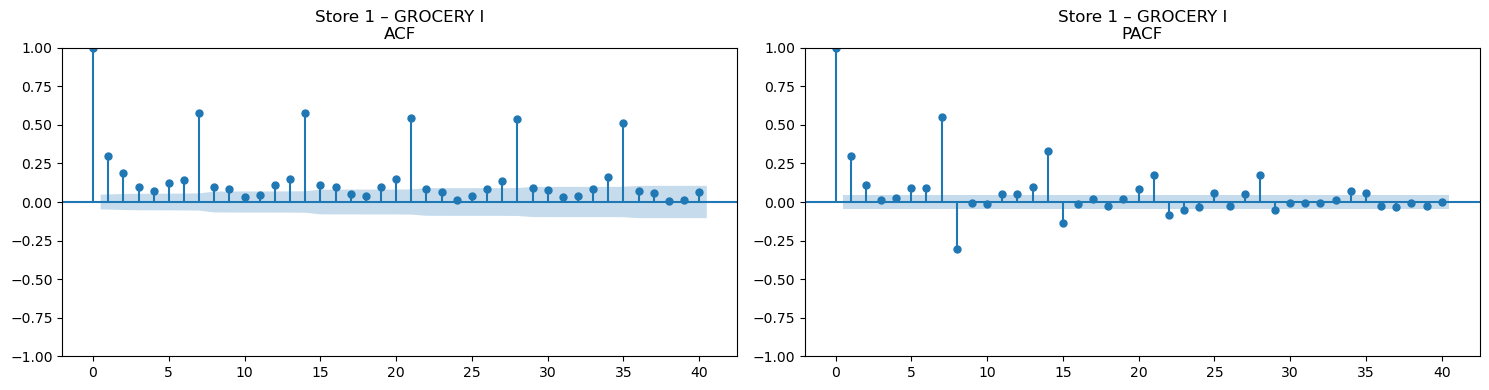

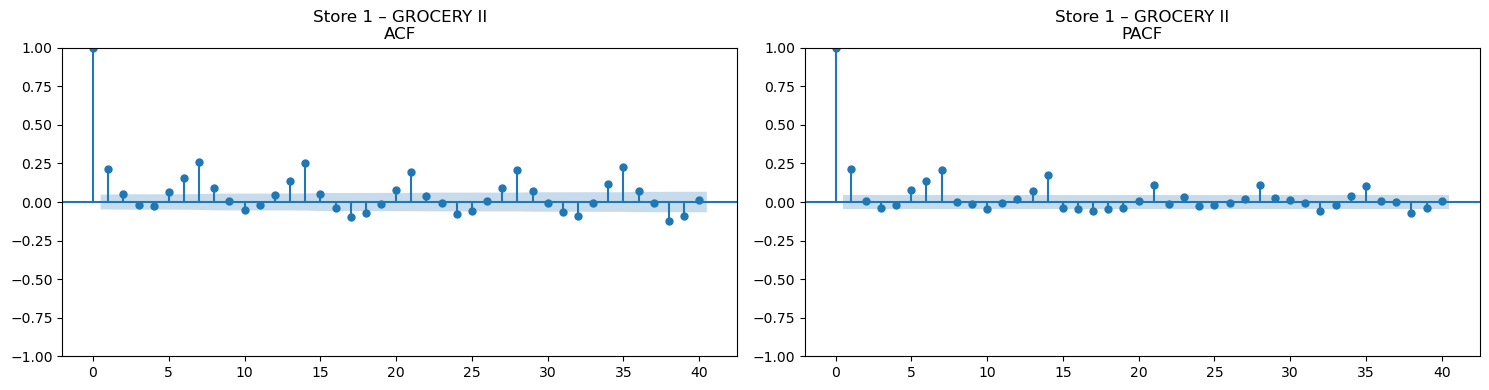

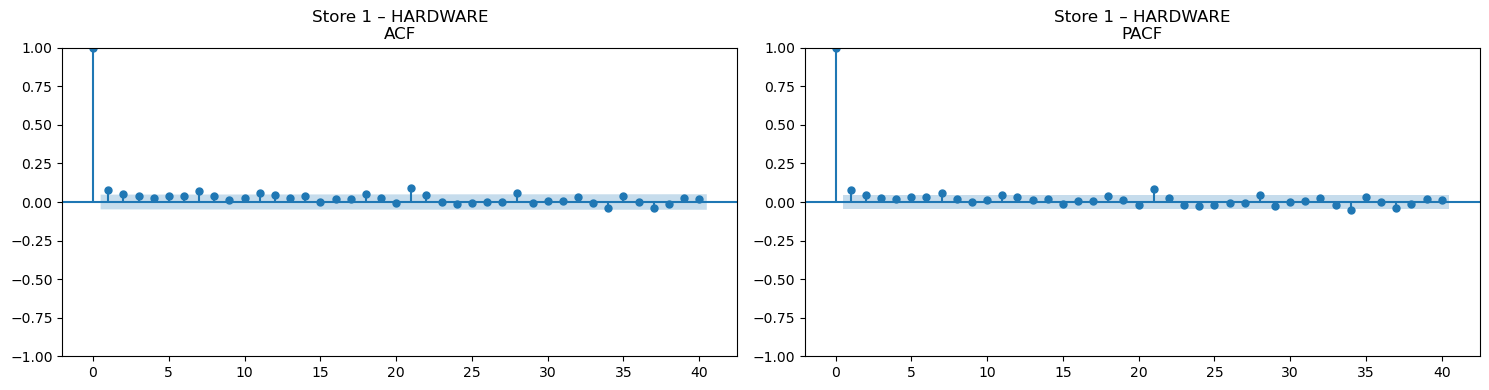

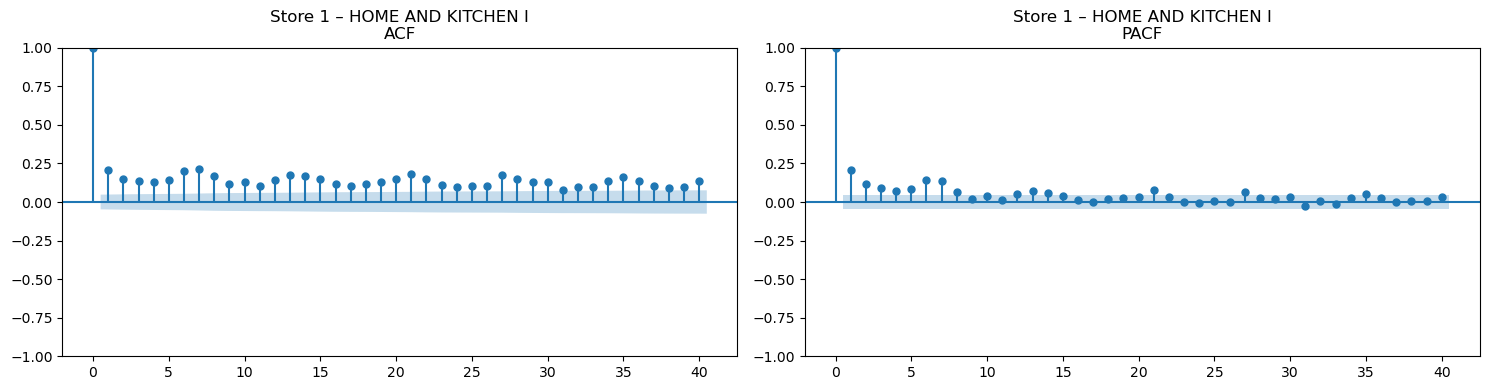

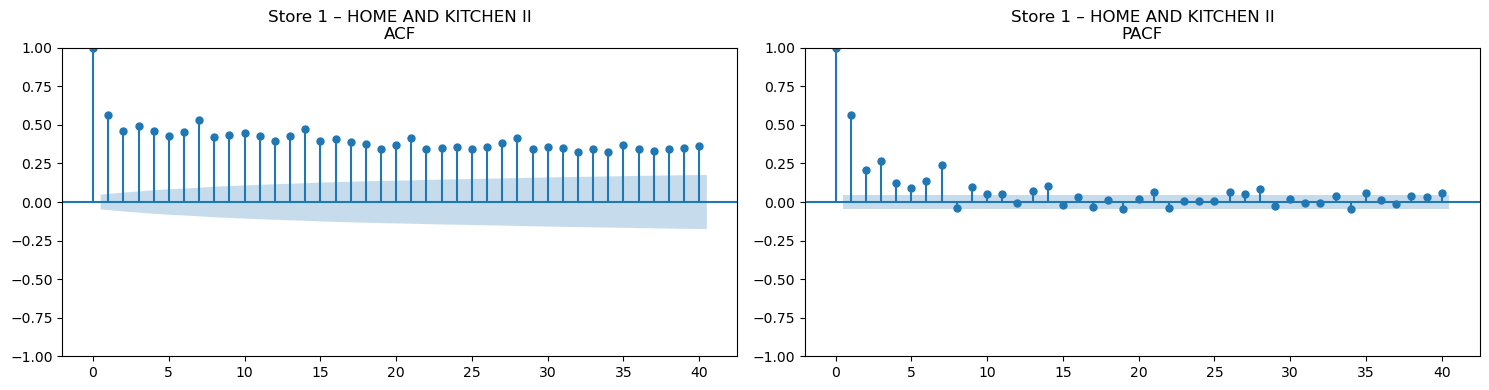

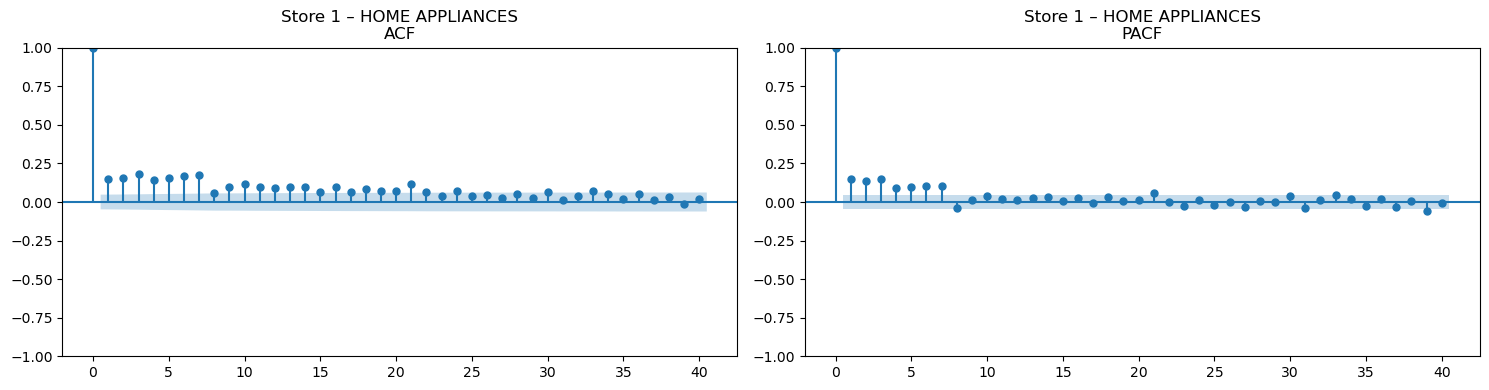

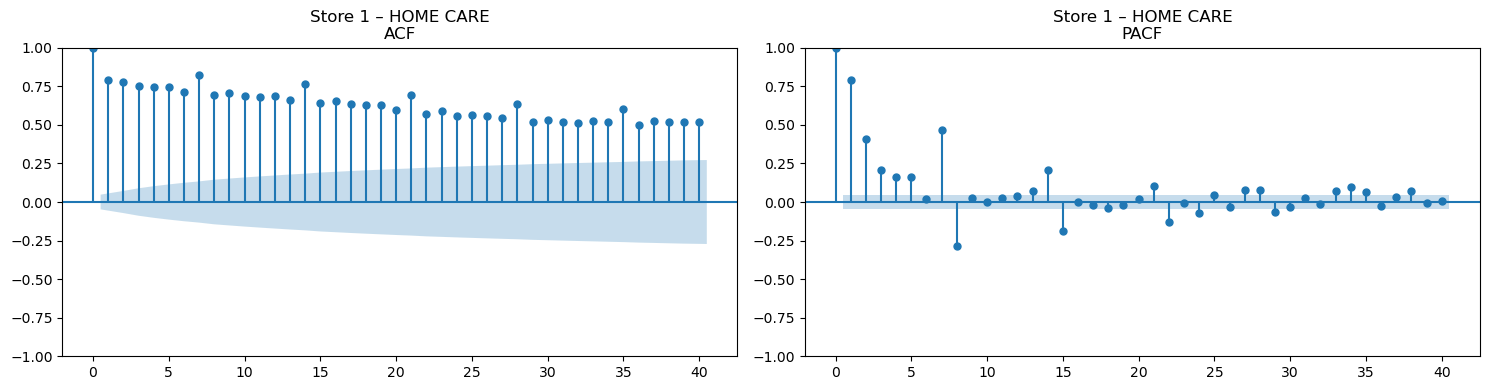

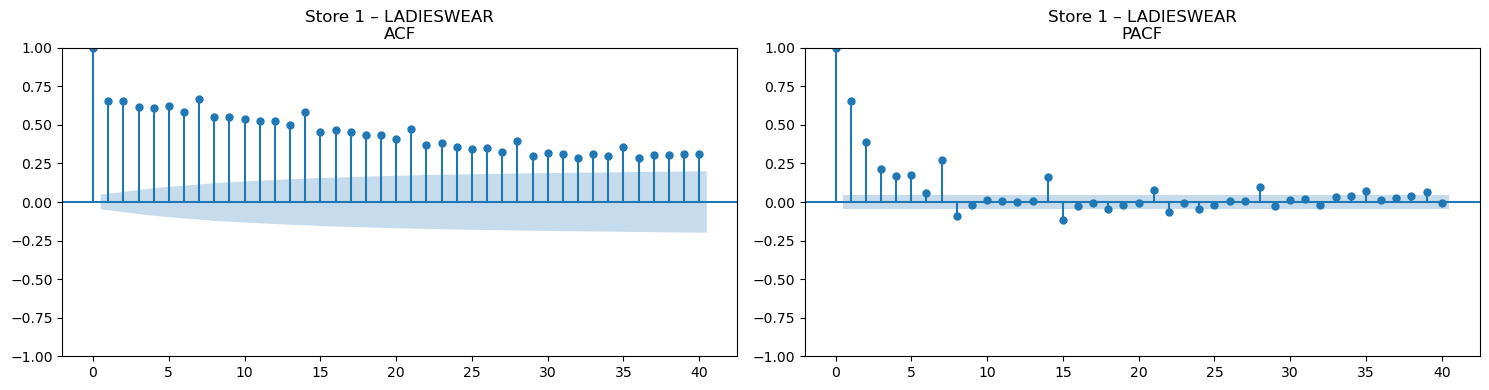

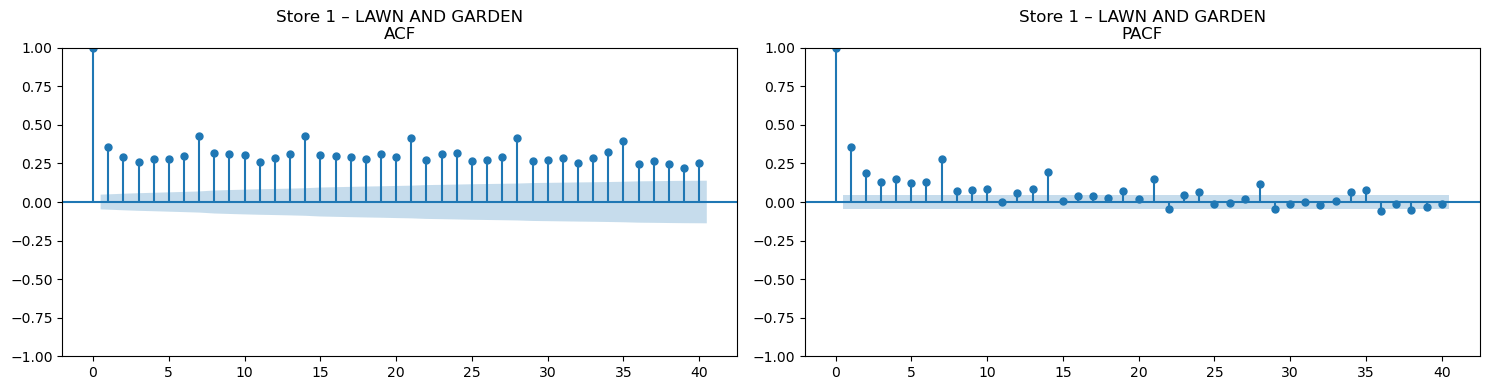

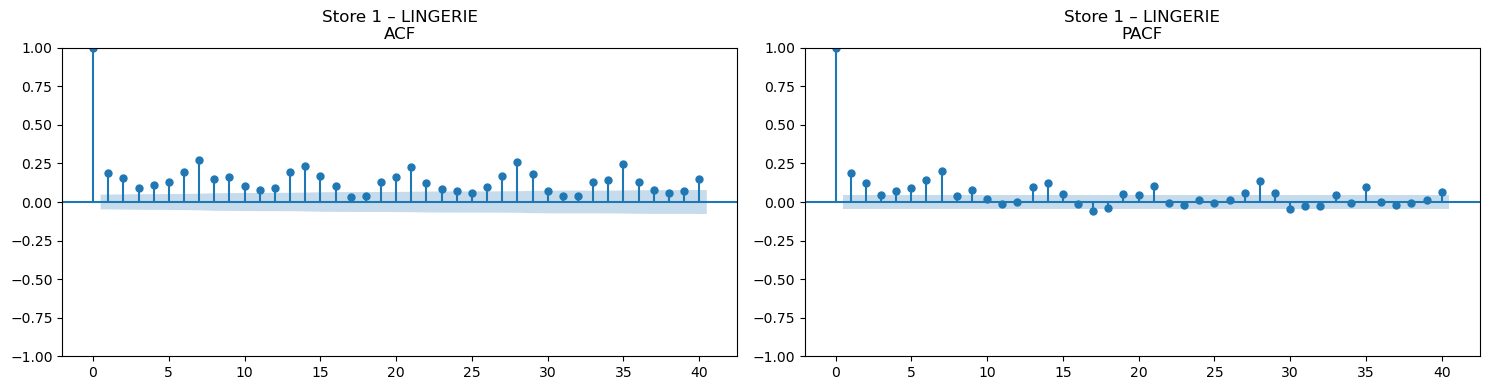

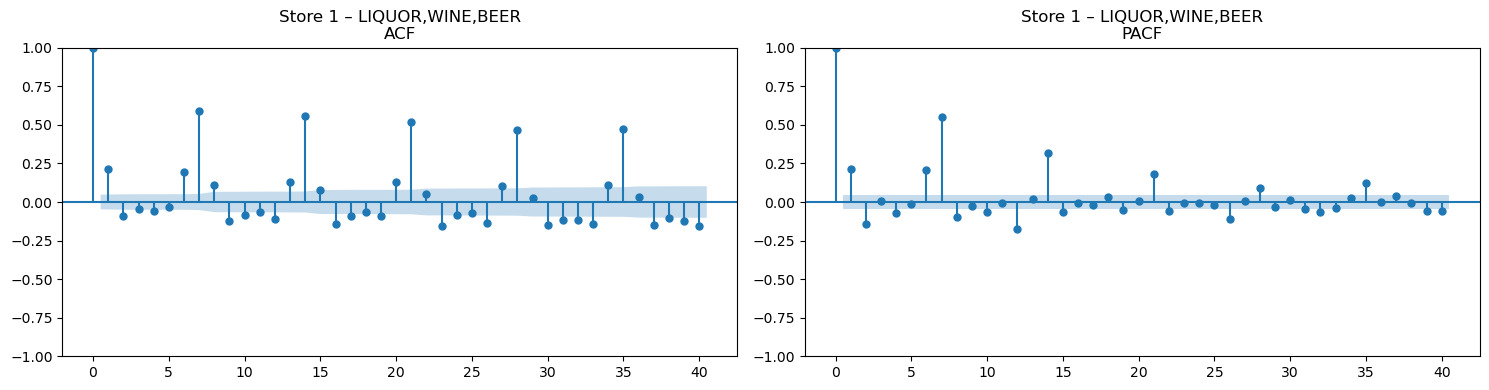

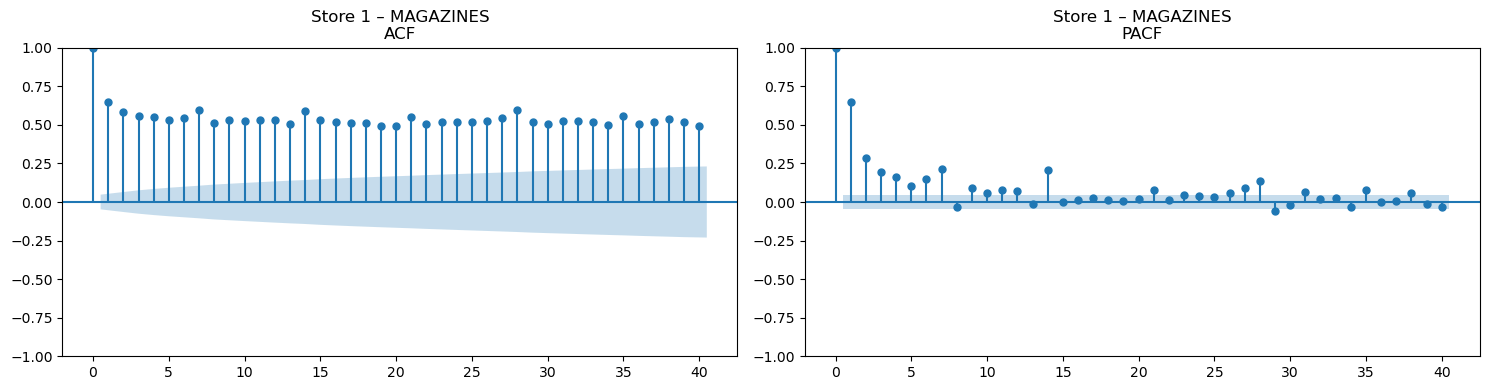

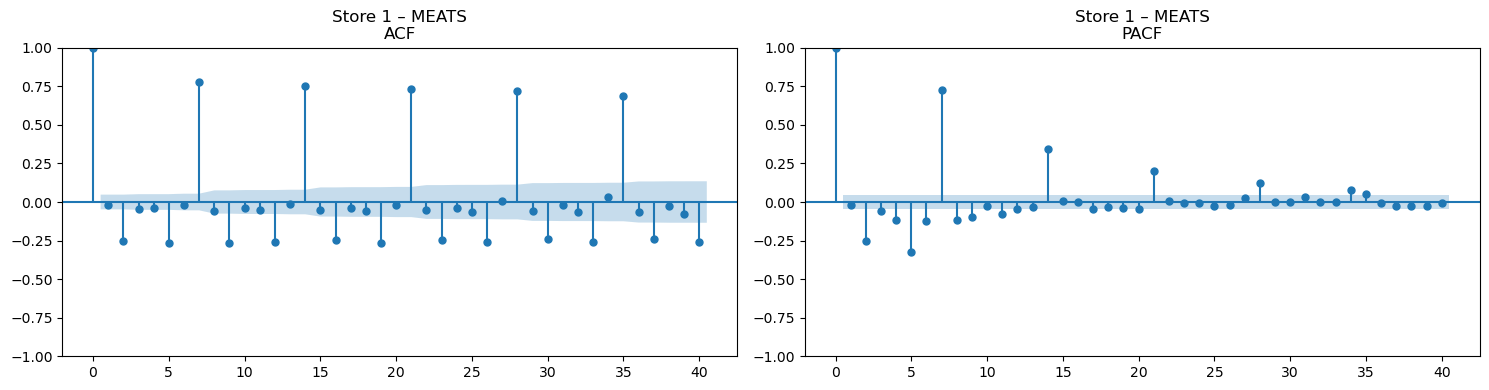

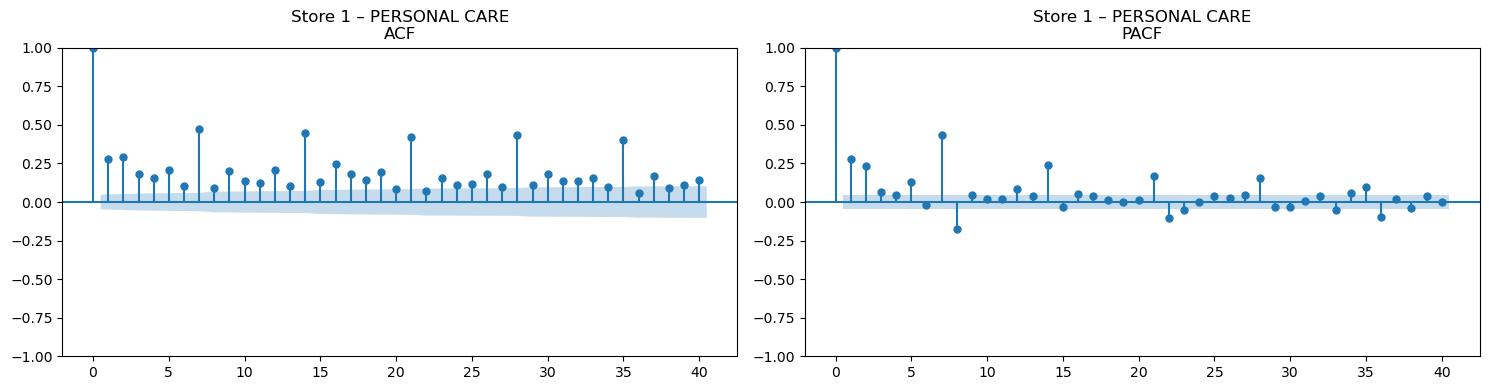

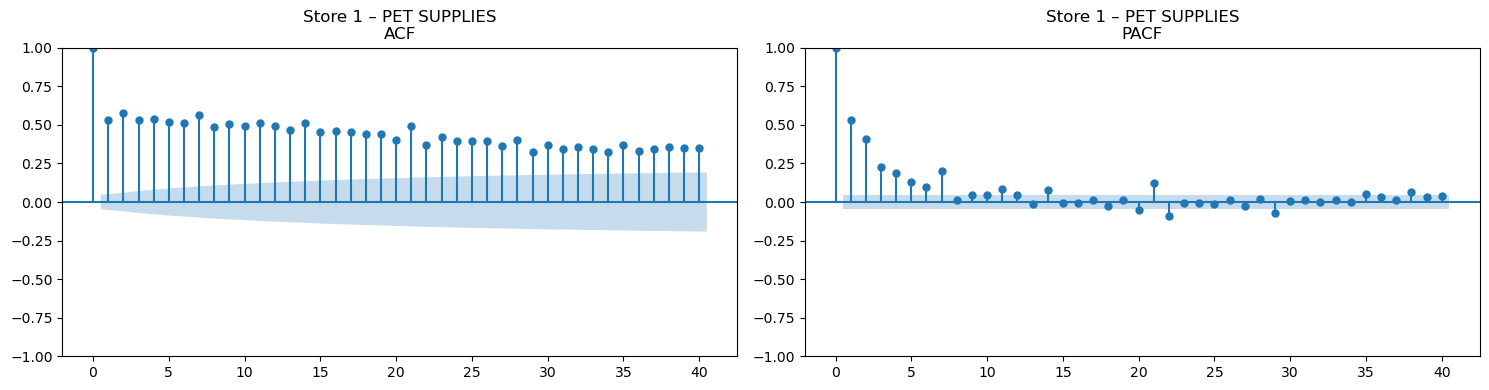

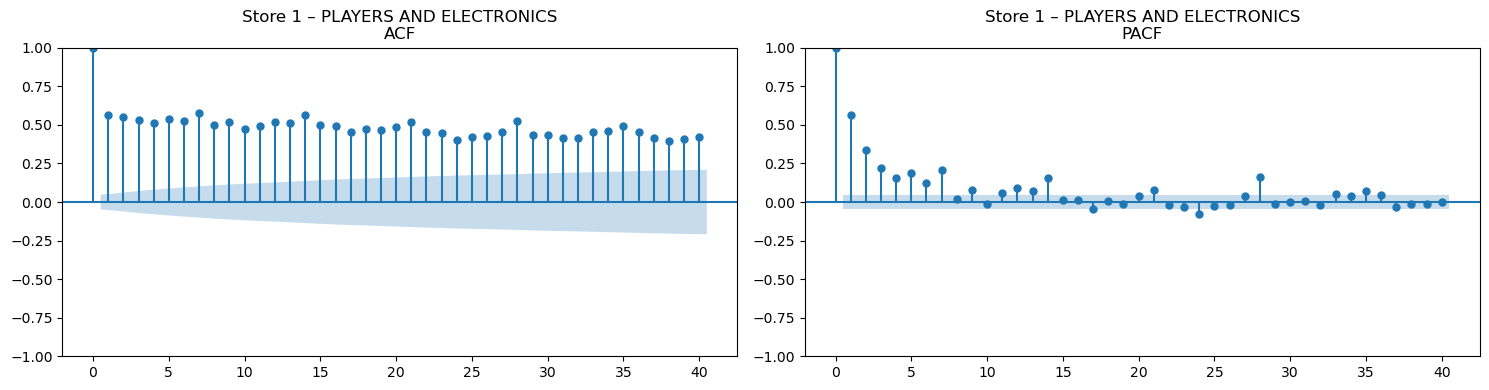

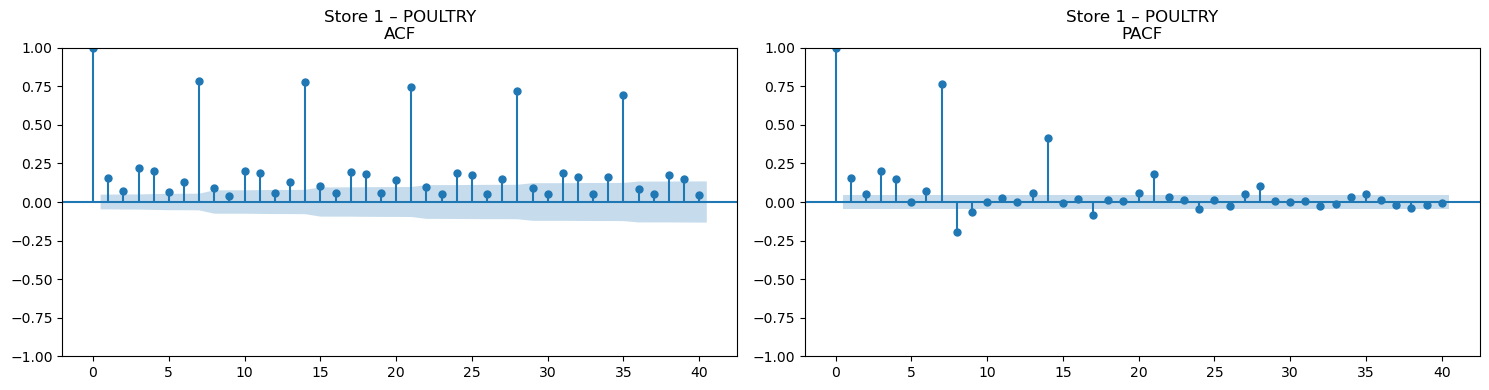

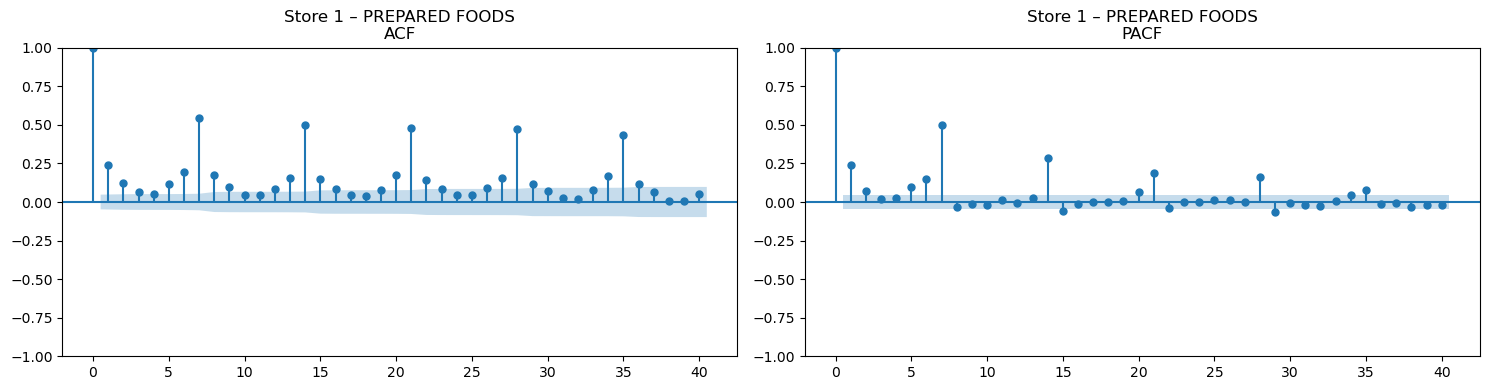

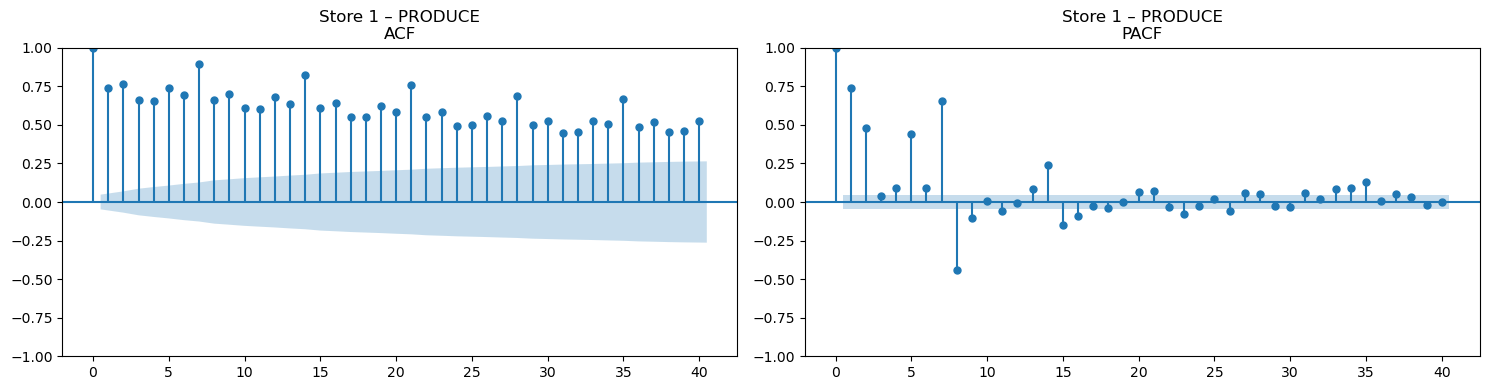

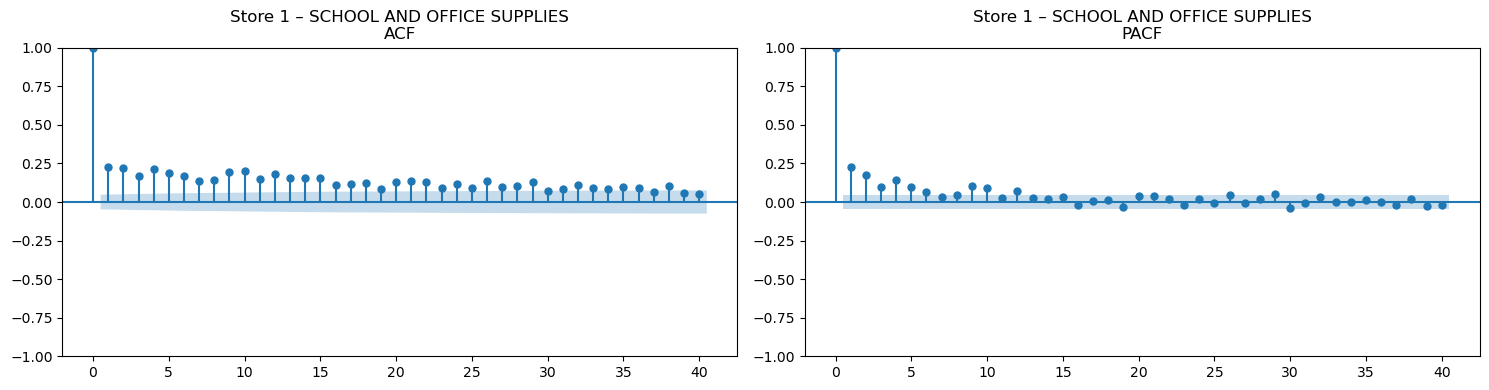

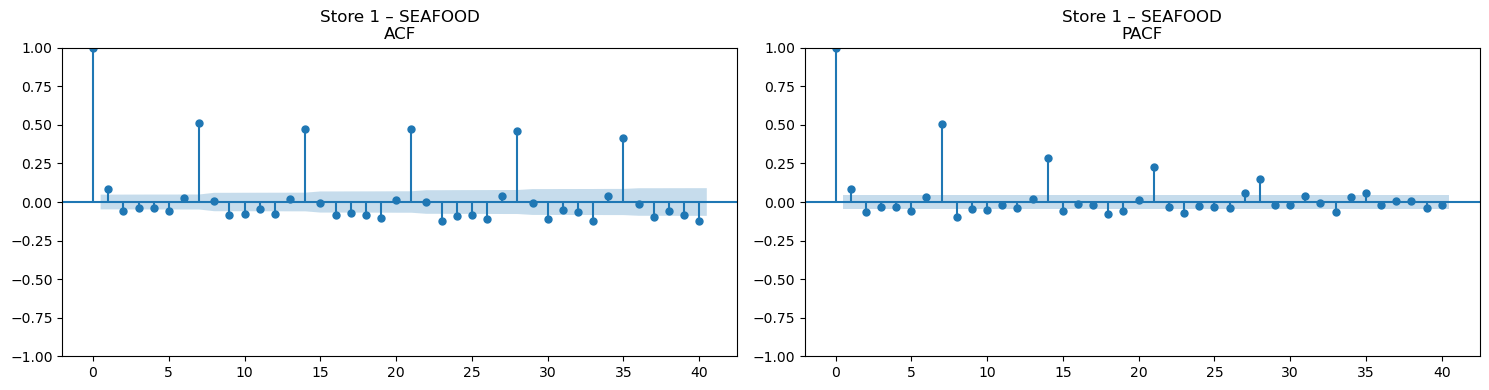

In [22]:
agg1 = (
    df[(df['store_nbr'] == 1) & df['sales'].notnull()]
    .groupby(['family', 'date'])['sales']
    .mean()
    .reset_index()
)

# 3. Loop over each family in store 1
for fam, grp in agg1.groupby('family'):
    ts = grp.set_index('date')['sales']

    try:
        fig, axes = plt.subplots(1, 2, figsize=(15, 4))
        sm.graphics.tsa.plot_acf(ts, lags=40, ax=axes[0])
        axes[0].set_title(f'Store 1 – {fam}\nACF')
        sm.graphics.tsa.plot_pacf(ts, lags=40, ax=axes[1])
        axes[1].set_title(f'Store 1 – {fam}\nPACF')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot family {fam}: {e}")

## Model training

In [23]:
train = df[df['date'] <= '2017-07-31']
test = df[(df['date'] > '2017-07-31') & (df['date'] <= '2017-08-15')]

print("Training period:", train['date'].min(), "to", train['date'].max())
print("Validation period:", test['date'].min(), "to", test['date'].max())
print("Train size:", len(train), "rows,", "Validation size:", len(test), "rows")
train.head()

Training period: 2013-01-01 00:00:00 to 2017-07-31 00:00:00
Validation period: 2017-08-01 00:00:00 to 2017-08-15 00:00:00
Train size: 2974158 rows, Validation size: 26730 rows


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico,is_holiday,day,month,year,day_of_week,is_weekend,is_weekend_and_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,1393.0,67.878342,1.0,1,1,2013,1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,1393.0,67.878342,1.0,1,1,2013,1,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,1393.0,67.878342,1.0,1,1,2013,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,1393.0,67.878342,1.0,1,1,2013,1,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,1393.0,67.878342,1.0,1,1,2013,1,0,0


### SAIMAX model

In [24]:
series_key = (1, 'GROCERY I')
train_series = train[(train['store_nbr']==series_key[0]) & 
                           (train['family']==series_key[1])]
val_series = test[(test['store_nbr']==series_key[0]) & 
                       (test['family']==series_key[1])]


y_train = train_series['sales']
exog_features = ['onpromotion', 'is_holiday', 'dcoilwtico', 'transactions']
exog_train = train_series[exog_features]

sarimax_model = SARIMAX(y_train, exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,7), 
                        enforce_stationarity=False, enforce_invertibility=False)
sarimax_result = sarimax_model.fit(disp=False)
print(sarimax_result.summary().tables[1])  
n_val = len(val_series)
exog_val = val_series[exog_features]
sarimax_forecast = sarimax_result.forecast(steps=n_val, exog=exog_val)
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

series_rmsle = rmsle(val_series['sales'].values, sarimax_forecast.values)
print(f"SARIMAX validation RMSLE for store {series_key[0]}, family {series_key[1]}: {series_rmsle:.4f}")

                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
onpromotion      5.3473      0.610      8.769      0.000       4.152       6.542
is_holiday     -80.8851     32.132     -2.517      0.012    -143.862     -17.908
dcoilwtico     -33.1567      5.893     -5.627      0.000     -44.706     -21.608
transactions     1.2234      0.029     42.494      0.000       1.167       1.280
ar.L1            0.3605      0.014     26.169      0.000       0.333       0.387
ma.L1           -1.0507      0.009   -116.925      0.000      -1.068      -1.033
ar.S.L7         -0.0022      0.024     -0.093      0.926      -0.049       0.044
ma.S.L7         -0.8748      0.017    -50.302      0.000      -0.909      -0.841
sigma2        1.485e+05   2766.743     53.656      0.000    1.43e+05    1.54e+05
SARIMAX validation RMSLE for store 1, family GROCERY I: 0.1419


In [56]:
results = []
combinations = train[['store_nbr', 'family']].drop_duplicates()

for _, row in combinations.iterrows():
    store, family = row['store_nbr'], row['family']
    
    train_series = train[(train['store_nbr'] == store) & (train['family'] == family)]
    val_series   = test[(test['store_nbr'] == store) & (test['family'] == family)]

    if len(train_series) < 30 or len(val_series) == 0:
        continue

    try:
        y_train = train_series['sales']
        exog_train = train_series[exog_features]
        exog_val   = val_series[exog_features]

        model = SARIMAX(
            y_train, exog=exog_train,
            order=(1, 1, 1), seasonal_order=(1, 1, 1, 7),
            enforce_stationarity=False, enforce_invertibility=False
        )
        result = model.fit(disp=False)
        forecast = result.forecast(steps=len(val_series), exog=exog_val)

        rmsle_score = rmsle(val_series['sales'].values, forecast.values)
        results.append({'store_nbr': store, 'family': family, 'rmsle': rmsle_score})
    except Exception as e:
        print(f"Skipped ({store}, {family}) due to error: {e}")
        continue


results_df = pd.DataFrame(results)
results_df.to_csv("sarimax_rmsle_results.csv", index=False)
print(results_df.sort_values('rmsle').head(10))

      store_nbr      family  rmsle
829          32       BOOKS    0.0
1354         47   BABY CARE    0.0
679          28  LADIESWEAR    0.0
37           10       BOOKS    0.0
877          33  LADIESWEAR    0.0
664          28       BOOKS    0.0
1240         43  LADIESWEAR    0.0
250          16  LADIESWEAR    0.0
1141         40  LADIESWEAR    0.0
928          35       BOOKS    0.0


In [61]:
results = pd.DataFrame(results)
overall_rmsle = np.sqrt(np.mean(results['rmsle'] ** 2))

print("Overall RMSLE:", overall_rmsle)

Overall RMSLE: 0.42663089438997875


### CatBoost

In [50]:
X_train = train.drop(columns=['date', 'sales'])
X_test = test.drop(columns=['date', 'sales'])
y_train = train['sales']
y_test = test['sales']

from catboost import CatBoostRegressor
cat_feature_names = ['family', 'city', 'state', 'type']  
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_feature_names]


model = CatBoostRegressor(
    iterations=600,
    learning_rate=0.1,
    depth=7,
    verbose=100
)

model.fit(
    X_train, 
    y_train, 
    cat_features=cat_feature_indices
)

preds = model.predict(X_test)

0:	learn: 1054.9797107	total: 638ms	remaining: 6m 21s
100:	learn: 358.6449079	total: 47.3s	remaining: 3m 53s
200:	learn: 323.2161544	total: 1m 40s	remaining: 3m 19s
300:	learn: 301.4173992	total: 2m 37s	remaining: 2m 36s
400:	learn: 287.4052151	total: 3m 32s	remaining: 1m 45s
500:	learn: 276.0157785	total: 4m 26s	remaining: 52.7s
599:	learn: 267.6864603	total: 5m 20s	remaining: 0us


In [51]:
rmsle_cat = rmsle(y_test, preds)
print(f"CatBoost validation RMSLE: {rmsle_cat:.4f}")

CatBoost validation RMSLE: 0.9997


## Deeplearning Models
### ANN

In [43]:
for col in cat_feature_names:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

num_cols = X_train.columns.difference(cat_feature_names).tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


input_dim = X_train.shape[1]

model_ann = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(64,  activation='relu'),
    Dropout(0.1),
    Dense(1) 
])
model_ann.compile(optimizer='adam', loss='mse')

history = model_ann.fit(
    X_train.values, y_train,
    validation_data=(X_test.values, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

ann_preds = model_ann.predict(X_test.values).flatten().clip(0)
print("ANN RMSLE:", rmsle(y_test, ann_preds))

Epoch 1/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 35s 375us/step - loss: 724965.4375 - val_loss: 427405.8125
Epoch 2/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 36s 383us/step - loss: 395747.2812 - val_loss: 325056.9375
Epoch 3/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 36s 384us/step - loss: 318025.2812 - val_loss: 225053.8281
Epoch 4/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 37s 398us/step - loss: 270169.2812 - val_loss: 214891.3594
Epoch 5/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 38s 405us/step - loss: 256036.3281 - val_loss: 199257.5781
Epoch 6/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 35s 380us/step - loss: 251677.5469 - val_loss: 201097.6875
Epoch 7/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 34s 367us/step - loss: 226579.2031 - val_loss: 186281.5000
Epoch 8/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 34s 362us/step - loss: 224704.2344 - val_loss: 173584.9688
Epoch 9/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 34s 369us/step - loss: 226496.9844 - val_loss: 171293.4531
Epoch 10/50
92943/92943 ━━━━━━━━━━━━━━━━━━━━ 36s 389us/step - loss: 21044

### CNN

In [ ]:
full = pd.concat([train, test]) \
         .sort_values(['store_nbr','family','date']) \
         .reset_index(drop=True)


le_store = LabelEncoder()
full['store_enc'] = le_store.fit_transform(full['store_nbr'])
le_fam   = LabelEncoder()
full['fam_enc']   = le_fam.fit_transform(full['family'])


seq_feats = [
    'sales', 'onpromotion', 'is_holiday', 
    'dcoilwtico', 'transactions', 
    'store_enc', 'fam_enc'
]

N = 14
train_max_date = train['date'].max()

X_tr_seq, y_tr_seq = [], []
X_te_seq, y_te_seq = [], []


for (_, _), grp in full.groupby(['store_nbr','family']):
    grp = grp.sort_values('date').reset_index(drop=True)
    for i in range(N, len(grp)):
        window = grp.loc[i-N:i-1, seq_feats].values          
        target_date = grp.loc[i, 'date']
        target_sale = grp.loc[i, 'sales']
        
        if target_date <= train_max_date:
            X_tr_seq.append(window);  y_tr_seq.append(target_sale)
        else:
            X_te_seq.append(window);  y_te_seq.append(target_sale)

X_tr_seq = np.array(X_tr_seq)
y_tr_seq = np.array(y_tr_seq)
X_te_seq = np.array(X_te_seq)
y_te_seq = np.array(y_te_seq)

print("train seq:", X_tr_seq.shape, "test seq:", X_te_seq.shape)



train seq: (2949210, 14, 7) test seq: (26730, 14, 7)


NameError: name 'Flatten' is not defined

In [59]:
model_cnn = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(N, len(seq_feats))),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1) 
])
model_cnn.compile(optimizer='adam', loss='mse')

history = model_cnn.fit(
    X_tr_seq, y_tr_seq,
    validation_data=(X_te_seq, y_te_seq),
    epochs=20,
    batch_size=64,
    verbose=1
)


cnn_preds = model_cnn.predict(X_te_seq).flatten().clip(0)
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred)-np.log1p(y_true))**2))

print("CNN RMSLE:", rmsle(y_te_seq, cnn_preds))

Epoch 1/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 32s 689us/step - loss: 146681.0156 - val_loss: 90892.6797
Epoch 2/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 29s 625us/step - loss: 76827.0547 - val_loss: 64996.5391
Epoch 3/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 28s 606us/step - loss: 82135.6719 - val_loss: 57614.9102
Epoch 4/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 28s 606us/step - loss: 72212.2578 - val_loss: 62621.5430
Epoch 5/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 28s 607us/step - loss: 77133.5234 - val_loss: 59538.0586
Epoch 6/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 28s 612us/step - loss: 70197.7500 - val_loss: 72716.6484
Epoch 7/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 1409s 31ms/step - loss: 73327.0391 - val_loss: 53333.1328
Epoch 8/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 27s 575us/step - loss: 70030.2266 - val_loss: 79379.4531
Epoch 9/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 27s 593us/step - loss: 76086.3125 - val_loss: 55868.1289
Epoch 10/20
46082/46082 ━━━━━━━━━━━━━━━━━━━━ 28s 617us/step - loss: 67867.5391 - val_loss

## The best model CatBoost
### training submission data

In [ ]:
features = df.drop(columns=['date', 'sales'])
cat_feature_indices = [features.columns.get_loc(col) for col in cat_feature_names]
model = CatBoostRegressor(
    iterations=600,
    learning_rate=0.1,
    depth=7,
    verbose=100
)
model.fit(
    features, 
    df['sales'], 
    cat_features=cat_feature_indices
)

0:	learn: 1056.2901431	total: 601ms	remaining: 5m 59s
100:	learn: 367.3552426	total: 47s	remaining: 3m 52s
200:	learn: 326.4408369	total: 1m 35s	remaining: 3m 10s
300:	learn: 304.3553557	total: 2m 24s	remaining: 2m 23s
400:	learn: 290.4660154	total: 3m 12s	remaining: 1m 35s
500:	learn: 279.5679376	total: 4m 6s	remaining: 48.6s
599:	learn: 270.6415999	total: 5m 1s	remaining: 0us


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="AUTOMOTIVE": Cannot convert 'b'AUTOMOTIVE'' to float

In [ ]:
X_submission = submission[features.columns]  
preds = model.predict(X_submission)
sub = submission[['id']].copy()
sub['sales'] = preds.clip(0)
sub.to_csv('submission_catboost.csv', index=False)

## Random Forest

In [66]:
X_train_enc = train.drop(columns=['date', 'sales']).copy()
y_train = train['sales']

X_test_enc  = test.drop(columns=['date', 'sales']).copy()
y_test = test['sales']

# Identify object columns (categoricals)
cat_cols = X_train_enc.select_dtypes(include=['object', 'category']).columns

# Label encode them
for col in cat_cols:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train_enc[col].astype(str))
    X_test_enc[col]  = le.transform(X_test_enc[col].astype(str))

# Now you can fit the RandomForest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_enc, y_train)

# Predict
rf_preds = rf.predict(X_test_enc)

# Evaluate
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

print("Random Forest RMSLE:", rmsle(y_test, rf_preds))

Random Forest RMSLE: 0.49665852946033556


In [67]:
target = df['sales']

cat_cols = features.select_dtypes(include=['object', 'category']).columns
submission_enc = X_submission.copy()

features_enc = features.copy()
for col in cat_cols:
    le = LabelEncoder()
    features_enc[col] = le.fit_transform(features_enc[col].astype(str))
    submission_enc[col] = le.transform(submission_enc[col].astype(str))


rf = RandomForestRegressor(random_state=42,)
rf.fit(features_enc, target)
submission_preds = rf.predict(submission_enc)


### Creating submission

In [69]:
submission_preds = pd.DataFrame({
    'id': submission['id'],
    'sales': submission_preds.clip(0)
})
submission_preds.to_csv('submission_pred.csv', index=False)